In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter


## URl
https://www.kaggle.com/code/marcinrutecki/best-techniques-and-metrics-for-imbalanced-dataset/notebook#9.-SMOTE-(Synthetic-Minority-Oversampling-Technique)

### Visualize imblance

In [2]:
raw_df = pd.read_csv("creditcard.csv")

labels = ["Genuine", "Fraud"]

fraud_or_not = raw_df['Class'].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]] #first genuine, second fraud

fig = px.pie(values=raw_df['Class'].value_counts(), names=labels, width=700, height=400, color_discrete_sequence=['skyblue', 'black'], title='Fraud vs Genuine')

fig.show()


/tmp/ipykernel_13503/2276374291.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




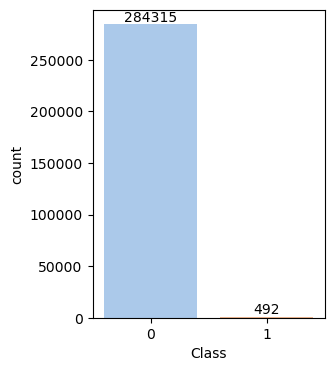

In [3]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='Class', data=raw_df, palette='pastel') #创建barplot x是column name
#为barplot 添加annotation
for i in ax.containers:
    ax.bar_label(i,)

In [4]:
print(raw_df['Class'].value_counts())
print('Genuine', round(raw_df['Class'].value_counts()[0]/len(raw_df) * 100,2), '% of the dataset')
print('Fraud', round(raw_df['Class'].value_counts()[1]/len(raw_df) * 100,2), '% of dataset')

Class
0    284315
1       492
Name: count, dtype: int64
Genuine 99.83 % of the dataset
Fraud 0.17 % of dataset


### Dropping duplicate



In [5]:
df = raw_df.copy() #ONLY DROP DUPLICATE

df.drop_duplicates(inplace=True)
df = df.drop('Time',axis=1) #drop time column
print("dropping", len(raw_df) - len(df))


dropping 1081


### Why we shouldn't delete outliers in this case

#### Checking for outliers and visualization


In [6]:
print(df.columns)
numeric_columns = (list(df.loc[:, 'V1':'Amount'])) #numeric column name

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')


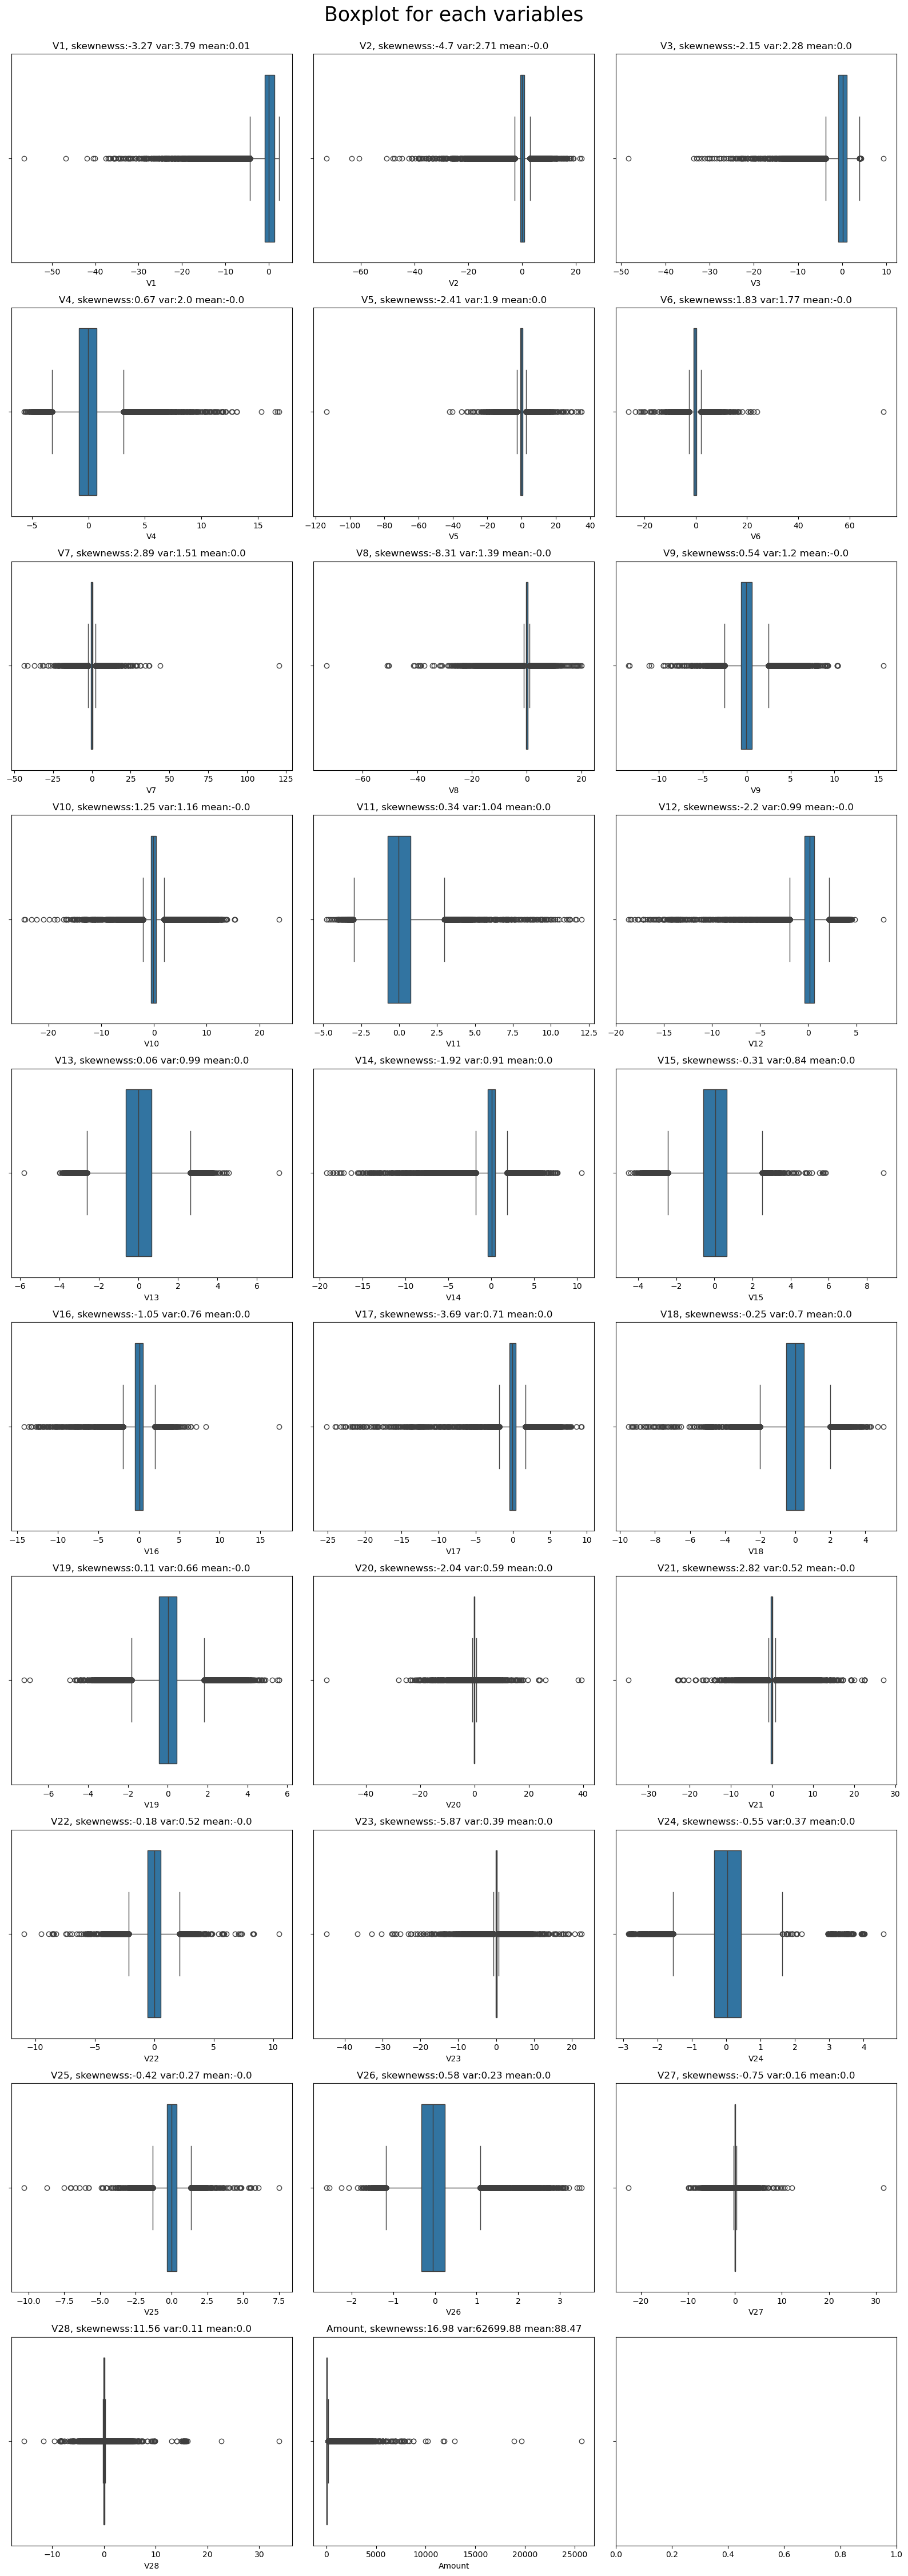

In [7]:
def boxplot_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(16,45))
    fig.suptitle(suptitle, y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list): #column name
        sns.boxplot(dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data+', skewnewss:'+str(round(dataset[data].skew(axis=0, skipna=True),2))+
                         " var:"+str(round(dataset[data].var(axis=0,skipna=True),2))+
                         " mean:"+str(round(dataset[data].mean(axis=0,skipna=True),2)))

boxplot_custom(dataset=df, columns_list=numeric_columns, rows=10, cols=3, suptitle='Boxplot for each variables')
plt.tight_layout()

#### Inter Quartile Range(IQR)
Significant outliers
* huge outliers
* highly skeved data
* a lot of outliers

Anything not in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR) is an outlier, and can be removed

Procedure:
1. Find the first qurtile, Q1
2. Find the third quartile, Q3
3. Calculate the IQR. IQR=Q3-Q1
4. Define the normal data range with lower limit as Q1–1.5 IQR and upper limit as Q3+1.5 IQR.


In [8]:
def IQR_method(df, n, features):
    """Taking a dataframe and return an index list corresponding to the observations
    containing more than n outliers according to IQR method"""

    outliers_list = []
    for column in features:
        Q1 = np.percentile(df[column], 25)
        Q3 = np.percentile(df[column], 75)
        IQR = Q3-Q1

        outlier_step = 1.5*IQR
        #determine a list of indices of outliers
        #每个column里只要有值是outlier， 这一行的index就会被放到outliers_list
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step)].index
        outliers_list.extend(outlier_list_column)

    outliers_list = Counter(outliers_list) #input: list , return dict of count

    #select observations containing more than n outliers, return a list of index
    #如果这一行的outlier的column超过n
    multiple_outliers = list(k for k, v in outliers_list.items() if v > n)
    print("The total number of deleted outliers is: ", len(multiple_outliers))

    return multiple_outliers


In [9]:
outlier_IQR = IQR_method(df, n=1,features=numeric_columns)
df_out = df.drop(outlier_IQR, axis=0).reset_index(drop=True) #DATAFRAME THAT DROP OUTLIER

The total number of deleted outliers is:  81014


/tmp/ipykernel_13503/909300630.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




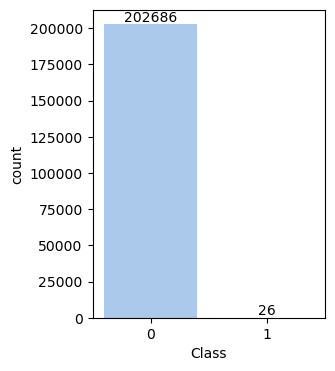

In [10]:
#### Conclusion
plt.figure(figsize=(3,4))
ax = sns.countplot(x="Class", data=df_out, palette="pastel")
for i in ax.containers:
    ax.bar_label(i,)


only 26 observations of fraud 

###

### Train test split


#### Stratified splitting
**Stratified splitting** means that generating training/testing dataset, and keep same percentage of class in each split

保持样本class的比例

In [11]:
x = df.drop('Class', axis=1)
y = df['Class']


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train,Y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=42)
print(Y_train.value_counts())
print(Y_test.value_counts())

Class
0    198277
1       331
Name: count, dtype: int64
Class
0    84976
1      142
Name: count, dtype: int64


#### Oversampling/undersampling

Always oversampling/undersampling before splilting


### Feature scaling
 1. standardscalar 

       transform to 0 mean and unit varience

<Axes: xlabel='Amount', ylabel='Count'>

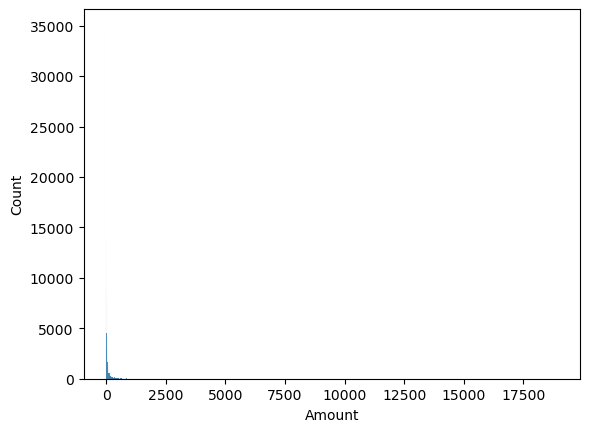

In [13]:
from sklearn.preprocessing import StandardScaler

def Standard_Scalar(df, col_names):
    features = df[col_names]
    scalar = StandardScaler().fit(features.values)
    features = scalar.transform(features.values)
    df[col_names] = features

    return df
sns.histplot(X_train['Amount'])

<Axes: xlabel='Amount', ylabel='Count'>

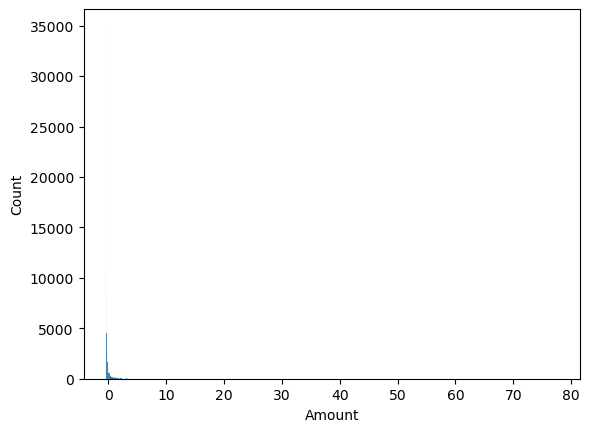

In [14]:
colnames = ['Amount']
X_train = Standard_Scalar(df=X_train, col_names=colnames)
sns.histplot(X_train['Amount'])

### Baseline(no oversampling)



In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

kf = StratifiedKFold(n_splits=5, shuffle=False) #分层抽样，保持每个样本中每个class的比例相同

rf = RandomForestClassifier(n_estimators=100, random_state=13)
cross_val_score(rf,X_train, Y_train, cv=kf, scoring="recall")

array([0.8030303 , 0.74242424, 0.76119403, 0.87878788, 0.65151515])

### Hyperparameter tuning using GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 10, 12],
    'random_state': [13]
}

grid_rf = GridSearchCV(rf, param_grid=params, cv=kf,
                          scoring='recall').fit(X_train, Y_train)